In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.externals import joblib

plt.style.use('ggplot')

In [22]:
#Loading Data....
data = atecml.data.load_train()
train_df = atecml.data.filter_date(data,start_date='2017-09-05',end_date='2017-10-15')
val_df = atecml.data.filter_date(data,start_date='2017-10-16',end_date='2018-10-15')

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]

#Loading Data....
data = atecml.data.load_train()
predictors = [x for x in data.columns if x not in atecml.data.NOT_FEATURE_SUM]


feature_tree_num = 20
train_model =[]
target_list = ['Normal','Fraud']
#target_list = ['Normal']
#target_list = ['Fraud']

for idx in range(0,1):
    for item in ['dart','gbdt']:
        for feature_grp_idx in range(0,feature_tree_num):
            for target in target_list:
                train_id = item + '__'+target +'__'+str(idx) +'__' + str(feature_grp_idx)
                train_model.append(train_id)

                
def model_load(model_name):
    model_cache_name = './'+model_name+'.model'
    if (os.path.exists(model_cache_name)):
        clf = joblib.load(model_cache_name)
    else:
        print('ERROR...............')
    return clf


if (os.path.exists('./feature_list.dat')):
    print('Load Feature List from persistant store...')
    feature_list = joblib.load('./feature_list.dat')
else:
    print('Error: Feature Cache File missing...')


trained_model_list =[]
with atecml.data.timer('Classification: Model Training'):
    for train_id in tqdm(range(len(train_model))):
        fit_model = model_load(train_model[train_id])
        trained_model_list.append(fit_model)



  0%|          | 0/80 [00:00<?, ?it/s]

Load Feature List from persistant store...
[2018-06-28 14:19:16][Classification: Model Training] Begin ...


100%|██████████| 80/80 [00:01<00:00, 63.94it/s]

[2018-06-28 14:19:17][Classification: Model Training] End   ...[Elapsed: 1.26s]


In [54]:
def predict_proba_matrix(trained_model_list,df):
    low_band = 0.4
    high_band = 0.9
    data = df.reset_index(drop=True)
    verify_df =pd.DataFrame()
    with atecml.data.timer('Validation.....'):
        for idx in tqdm(range(len(trained_model_list))):
            clf = trained_model_list[idx]
            model_params = train_model[idx].split('__')
            f_idx = int(model_params[3])
            select_feature = feature_list[f_idx]
            y_predict = clf.predict(data[select_feature])
            if (model_params[1] == 'Fraud'):
                verify_df['n'+str(idx)] = abs(y_predict)
            else:
                verify_df['n'+str(idx)] = abs(1- y_predict)
            verify_df['mean']=verify_df.T.mean()
    result = pd.concat([verify_df,data['id']],axis=1)
    filter_id_list = list(result[(result['mean'] > low_band) & (result['mean'] < high_band)]['id'])
    residual_df = data[data['id'].isin(filter_id_list)].reset_index(drop=True)
    return result,residual_df

In [55]:
verify_df = atecml.data.load_train()
verify_data = atecml.data.filter_date(verify_df,start_date='2017-10-16',end_date='2018-10-15')
result,res = predict_proba_matrix(trained_model_list,verify_df)

  0%|          | 0/80 [00:00<?, ?it/s]

[2018-06-28 15:26:10][Validation.....] Begin ...


100%|██████████| 80/80 [11:27<00:00,  9.10s/it]


[2018-06-28 15:37:38][Validation.....] End   ...[Elapsed: 687.97s]


Ant-Score: 0.5325276357036793


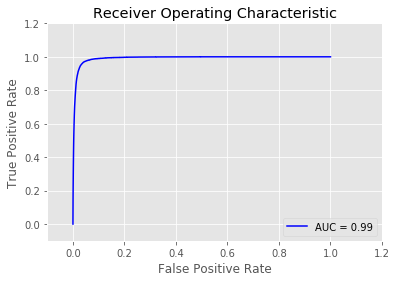

In [56]:
a,b,c=atecml.data.accuracy_validation(verify_df['Fraud'],result['mean'])

46784
10235
Ant-Score: 0.6193258426966293


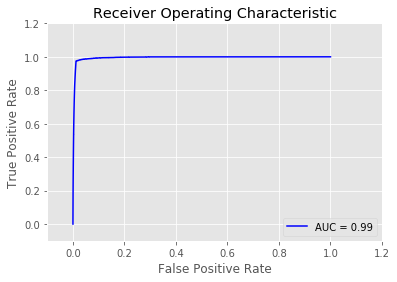

In [67]:
low_band=0.5
high_band = 0.9

filter_id_list = list(result[(result['mean'] > low_band) & (result['mean'] < high_band)]['id'])
print(len(filter_id_list))


temp_df = verify_df[~verify_df['id'].isin(filter_id_list)].reset_index(drop=True)
temp_df_proba = result[~result['id'].isin(filter_id_list)].reset_index(drop=True)

print(len(temp_df[temp_df['Fraud']==1]['id']))
a,b,c=atecml.data.accuracy_validation(temp_df['Fraud'],temp_df_proba['mean'])

Ant-Score: 0.03890853966649823


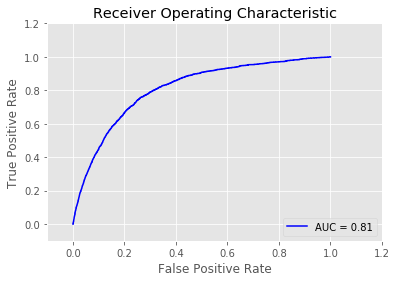

In [63]:
res_df = verify_df[verify_df['id'].isin(filter_id_list)].reset_index(drop=True)
res_df_proba = result[result['id'].isin(filter_id_list)].reset_index(drop=True)
d,e,f=atecml.data.accuracy_validation(res_df['Fraud'],res_df_proba['mean'])

In [68]:
pd.concat([temp_df,res_df],axis=1)

,id,label,date,f1,f2,f3,f4,f5,f6,f7,...,f291,f292,f293,f294,f295,f296,f297,NaN_LIST,Normal,Fraud
0,ef5ad2df31fc279cf5d32f6f0d9b045232a1ae0ebaa84e...,0,2017-09-05,0,1,0,1,100803.0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f5_f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30...,1.0,0.0
1,a439318d736ef43ce553b230e4524d8261dfe6877f7498...,0,2017-09-05,1,1,1,0,100804.0,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f5_f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30...,1.0,0.0
2,9835ec12489369f31bc4f07a107e06d48c659258c58003...,0,2017-09-05,1,0,2,1,NaN,1,4,...,3.0,4.0,1.0,1.0,2.0,1.0,2.0,f36_f37_f38_f39_f40_f41_f42_f43_f44_f45_f46_f47,1.0,0.0
3,52b8710cd3588f1cc6b5ddf1a2b480fb68a4ba0adecf50...,0,2017-09-05,0,0,1,0,100803.0,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f5_f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30...,1.0,0.0
4,1b99c2528ebac3fffc38646b93cd187165218ad40c05f1...,0,2017-09-05,1,1,1,1,100803.0,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f5_f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30...,1.0,0.0
5,ce30ac5fd27e6d919235c7d5dc1dfd353aafb4c8cd824b...,1,2017-09-05,1,1,1,0,NaN,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f5_f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30...,1.0,0.0
6,897f8aa6a7f3981fe8cd0daf7235927644031a8b6c31b7...,0,2017-09-05,1,1,1,1,100803.0,1,2,...,3.0,2.0,2.0,2.0,1.0,1.0,2.0,f36_f37_f38_f39_f40_f41_f42_f43_f44_f45_f46_f47,1.0,0.0
7,fd0caa21cb1ad798a71bdd4454a6f533b58d39cf3335c6...,0,2017-09-05,0,0,1,1,100804.0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f5_f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30...,1.0,0.0
8,a9942d97bf8ac9ccadffe41bb37aee97e8aa8696ab2c43...,0,2017-09-05,2,0,1,0,100610.0,0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f5_f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30...,1.0,0.0
9,832e3d3b7e6334db2bd1c957786241f992c4284e468c07...,0,2017-09-05,1,0,1,1,100803.0,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f5_f20_f21_f22_f23_f24_f25_f26_f27_f28_f29_f30...,1.0,0.0


In [59]:


res_train = pd.concat([result[result['id'].isin(list(res['id']))].reset_index(drop=True),res],axis=1)
res_train.to_pickle('./res.dat')

In [60]:
result.columns

Index(['n0', 'mean', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9',
       'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19',
       'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29',
       'n30', 'n31', 'n32', 'n33', 'n34', 'n35', 'n36', 'n37', 'n38', 'n39',
       'n40', 'n41', 'n42', 'n43', 'n44', 'n45', 'n46', 'n47', 'n48', 'n49',
       'n50', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n57', 'n58', 'n59',
       'n60', 'n61', 'n62', 'n63', 'n64', 'n65', 'n66', 'n67', 'n68', 'n69',
       'n70', 'n71', 'n72', 'n73', 'n74', 'n75', 'n76', 'n77', 'n78', 'n79',
       'id'],
      dtype='object')